<a href="https://colab.research.google.com/github/palberth/Modelos_y_Metodos_de_Sistemas_Inteligentes/blob/main/Sistema_Difuso_vs_%C3%81rbol_de_Decisi%C3%B3n_para_Clasificaci%C3%B3n_de_la_Calidad_del_Aire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##📘 Sistema Difuso vs Árbol de Decisión para Clasificación de la Calidad del Aire
###🎯 Objetivo
Comparar el enfoque basado en lógica difusa con un modelo de árbol de decisión para clasificar la calidad del aire en base a:

PM2.5 (µg/m³)

NO2 (ppb)

Proximidad a zonas industriales (km)

In [1]:
!pip install scikit-fuzzy matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


🌫️ 2. Sistema de Inferencia Difuso

###2.1. Definición de Variables

In [3]:
# Entradas
pm25 = ctrl.Antecedent(np.arange(0, 301, 1), 'PM2_5')
no2 = ctrl.Antecedent(np.arange(0, 71, 1), 'NO2')
proximidad = ctrl.Antecedent(np.arange(0, 26, 1), 'Proximidad')

# Salida
calidad_aire = ctrl.Consequent(np.arange(0, 101, 1), 'Calidad_Aire')

# Funciones de pertenencia
pm25['bajo'] = fuzz.trimf(pm25.universe, [0, 0, 15])
pm25['medio'] = fuzz.trimf(pm25.universe, [10, 25, 40])
pm25['alto'] = fuzz.trimf(pm25.universe, [30, 150, 300])

no2['bajo'] = fuzz.trimf(no2.universe, [0, 0, 20])
no2['medio'] = fuzz.trimf(no2.universe, [15, 30, 45])
no2['alto'] = fuzz.trimf(no2.universe, [40, 55, 70])

proximidad['cercano'] = fuzz.trimf(proximidad.universe, [0, 0, 5])
proximidad['medio'] = fuzz.trimf(proximidad.universe, [4, 8, 12])
proximidad['lejano'] = fuzz.trimf(proximidad.universe, [10, 20, 25])

calidad_aire['buena'] = fuzz.trimf(calidad_aire.universe, [0, 0, 30])
calidad_aire['moderada'] = fuzz.trimf(calidad_aire.universe, [20, 40, 60])
calidad_aire['mala'] = fuzz.trimf(calidad_aire.universe, [50, 70, 85])
calidad_aire['peligrosa'] = fuzz.trimf(calidad_aire.universe, [80, 100, 100])


###2.2. Reglas del Sistema Difuso

In [4]:
reglas = [
    ctrl.Rule(pm25['bajo'] & no2['bajo'] & proximidad['lejano'], calidad_aire['buena']),
    ctrl.Rule(pm25['bajo'] & no2['medio'] & proximidad['medio'], calidad_aire['moderada']),
    ctrl.Rule(pm25['medio'] & no2['medio'] & proximidad['cercano'], calidad_aire['mala']),
    ctrl.Rule(pm25['alto'] & no2['alto'] & proximidad['cercano'], calidad_aire['peligrosa']),
    ctrl.Rule(pm25['medio'] & no2['alto'] & proximidad['medio'], calidad_aire['mala']),
    ctrl.Rule(pm25['alto'] & no2['medio'] & proximidad['lejano'], calidad_aire['moderada']),
    ctrl.Rule(pm25['alto'] & no2['alto'] & proximidad['lejano'], calidad_aire['mala']),
    ctrl.Rule(pm25['medio'] & no2['bajo'] & proximidad['medio'], calidad_aire['moderada']),
    ctrl.Rule(pm25['bajo'] & no2['alto'] & proximidad['cercano'], calidad_aire['mala'])
]

sistema = ctrl.ControlSystem(reglas)
simulador = ctrl.ControlSystemSimulation(sistema)


###2.3. Simulación de *Ejemplo*

Calidad del aire estimada (difuso): 91.83


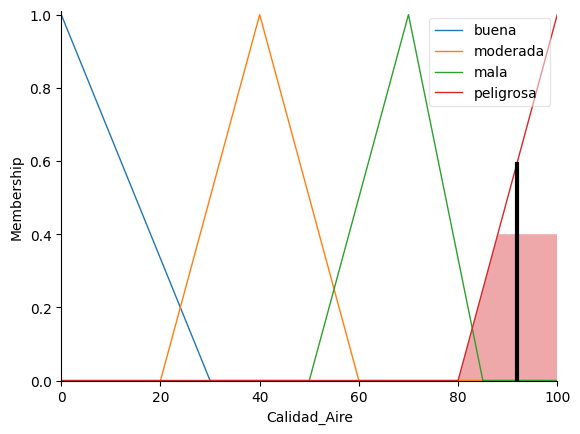

In [5]:
simulador.input['PM2_5'] = 120
simulador.input['NO2'] = 60
simulador.input['Proximidad'] = 3

simulador.compute()
print(f"Calidad del aire estimada (difuso): {simulador.output['Calidad_Aire']:.2f}")
calidad_aire.view(sim=simulador)


##🌳 3. Comparación con Árbol de Decisión

###3.1. Entrenamiento

In [7]:
df = pd.read_csv("/content/updated_pollution_dataset.csv", on_bad_lines='skip', encoding='latin-1')

X = df[['PM2.5', 'NO2', 'Proximity_to_Industrial_Areas']]
y = df['Air Quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)


3.2. Evaluación

              precision    recall  f1-score   support

        Good       0.96      1.00      0.98       618
   Hazardous       0.75      0.59      0.66       148
    Moderate       0.85      0.87      0.86       452
        Poor       0.69      0.67      0.68       282

    accuracy                           0.86      1500
   macro avg       0.81      0.78      0.80      1500
weighted avg       0.85      0.86      0.86      1500



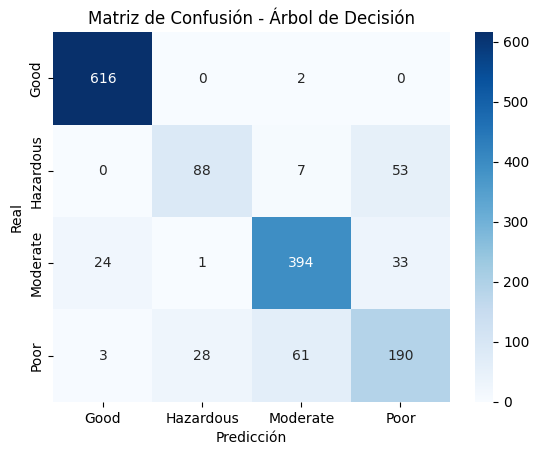

In [8]:
print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=modelo.classes_, yticklabels=modelo.classes_, cmap='Blues')
plt.title('Matriz de Confusión - Árbol de Decisión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


3.3. Visualización del Árbol

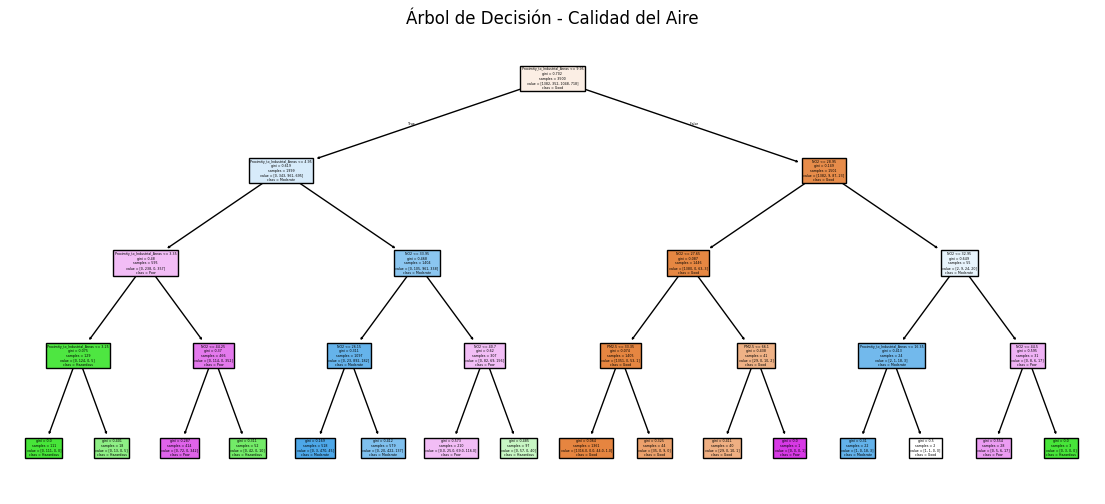

In [9]:
plt.figure(figsize=(14,6))
plot_tree(modelo, feature_names=X.columns, class_names=modelo.classes_, filled=True)
plt.title("Árbol de Decisión - Calidad del Aire")
plt.show()


✅ 4. Conclusión


Sistema Difuso: Ideal para representar reglas expertas. Es transparente, interpretativo y no requiere datos etiquetados.



Árbol de Decisión: Aprende automáticamente desde datos. Útil cuando se tiene un dataset completo y etiquetado.